# Deploy Model - By Booking - Target All Chronic
Prepared by Alex Aw & Le En

21 Aug 2022

## Colab setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd '/content/drive/MyDrive/EBAC Capstone 2021-2022/Team_members/Alex/deploy scoring'

## Import Library

In [3]:
import random 
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import numpy as np 
from numpy import unique
from numpy import where

import pickle

from pandas import to_pickle
from pandas import read_pickle

import io

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance

# Libraries for Modelling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn import metrics 
from sklearn import tree
from sklearn.metrics import roc_auc_score

# import scikitplot as skplt

import shap

from itertools import compress

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

## Global Setting

In [4]:
# Training Pickles Filename
PKL_ALL_FEATURE_FILENAME = "booking_model_all_featurelist.pkl"
PKL_STANDARDSCALER_FILENAME = "booking_model_all_standardard_scaler.pkl"
PKL_SELECT_MODEL_FILENAME = "booking_model_all_selectfeature.pkl"

In [5]:
# # Select 1 model to run
# PKL_MODEL_FILENAME = "booking_model_all_logistic.pkl"
PKL_MODEL_FILENAME = "booking_model_all_svm.pkl"
# PKL_MODEL_FILENAME = "booking_model_all_nonlinear_svm.pkl"
# PKL_MODEL_FILENAME = "booking_model_all_randomforest.pkl"
# PKL_MODEL_FILENAME = "booking_model_all_xgb.pkl"

In [6]:
# Testing Dataset
TEST_PREP_DATA = "booking_test_data_final_forBooking.pkl"

In [7]:
# Check is Target Label available
TARGET_AVAIL = 1

## Import Test Data

In [8]:
df = read_pickle(TEST_PREP_DATA)
df.shape

(7725, 332)

In [9]:
df.info("Deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7725 entries, 0 to 7724
Data columns (total 332 columns):
 #    Column                                     Dtype         
---   ------                                     -----         
 0    booking_id                                 object        
 1    mem_id                                     object        
 2    doctor_id                                  category      
 3    consult_waived_reason                      category      
 4    is_mc_issued                               int64         
 5    mc_days                                    float64       
 6    is_referral_letter_issued                  int64         
 7    booking_timestamp                          datetime64[ns]
 8    gender                                     category      
 9    birth_year                                 int64         
 10   diagnosis_code_list                        object        
 11   diagnosis_list                             object     

## Import Model Training Pickles

In [10]:
# Import training dataset feature list
with open(PKL_ALL_FEATURE_FILENAME, 'rb') as file:
    train_all_features = pickle.load(file)
print("Num of training features: ", len(train_all_features))

Num of training features:  114


In [11]:
# Import trained standard scaler model
with open(PKL_STANDARDSCALER_FILENAME, 'rb') as file:
    train_standardscaler = pickle.load(file)
train_standardscaler

StandardScaler()

In [12]:
# Import trained feature selection model
with open(PKL_SELECT_MODEL_FILENAME, 'rb') as file:
    train_selectfeature = pickle.load(file)
train_selectfeature

SelectFromModel(estimator=LinearSVC(random_state=42))

In [13]:
# Import trained classification model 
with open(PKL_MODEL_FILENAME, 'rb') as file:
    train_model = pickle.load(file)
train_model

SVC(kernel='linear', probability=True, random_state=42)

## Prepare Scoring Data

In [14]:
# removal listed columns
df = df.drop(['diagnosis_code_list', 'diagnosis_list', 'chronic_list', 'medicationID_list', 'medicationName_list',
        'medQuantity_list', 'medAndQuan_list', 'SymptomID_list', 'SymptomName_list'], axis=1)

In [15]:
all_list = df.columns.tolist()

In [16]:
#[TODO] EDIT TO INCLUDE CATEGORICAL INPUT TO CONSIDER
cat_list = ['gender',
           'doctor_id',
           'consult_waived_reason',
           ]
df[cat_list] = df[cat_list].astype("category")

In [17]:
# Currently type as float
int_list = ['mc_days', 
            'count_diagnosis', 
            'count_chronic', 
            'count_medication', 
            'count_repeatmed', 
            'count_SymID', 
            'age_yr']
df[int_list] = df[int_list].astype("int")

In [18]:
#[TODO] EDIT WHERE NEC
exc_list = ['booking_id', 
            'mem_id', 
            'birth_year', 
            'booking_timestamp',
            'count_chronic',
            'chronic_NoneChronic', 
            'chronic_Atopic dermatitis',
            'chronic_Migraine',
            'chronic_Vasomotor and allergic rhinitis',
            'chronic_Gastro-oesophageal reflux disease',
            'chronic_Hypertension',
            'chronic_Asthma',
            'chronic_Hyperlipidaemia',
            'chronic_Thyroid',
            'chronic_Diabetes',
            'chronic_Gout',
            'Target_chronic',
            'symp_chronic medicine top-up', 
            'symp_chronic illness management',
            'consult_waived_reason',
            
            ## diagnostics directly identifying chronics
            'diag_J30',  #Vasomotor and allergic rhinitis
            'diag_K21',  #Gastro-esophageal reflux disease
            'diag_G43',  #Migraine
            'diag_L20',  #Atopic dermatitis
            'diag_M10',  #Gout
            'diag_I10', 'diag_R03', #hypertension
            'diag_J45',  #Asthma
            'diag_E11',  #Diabetes
            'diag_E78',  #hypercholesterolemia, hyperglyceridemia, Hyperlipidemia (high cholesterol), Hyperchylomicronemia
            'diag_E05', 'diag_E03','diag_E04'   #thyroid
            ## end of diagnostics directly identifying chronics
            
           ]

In [19]:
# select columns not in exclusion list above
select_col = [x for x in all_list if x not in exc_list] 

In [20]:
# numerical data in selected list above
num_list = [x for x in select_col if x not in cat_list] 

In [21]:
# Check that all columns used in training are in the holdout test set.  
# If not, create a new column with value 0
for i in train_all_features:
    if i not in select_col:
        if str(i).startswith('gender' or 'doctor_id')==False:  #TODO need to include other categorical data if nec
            print("PLEASE CHECK, Selected field in training dataset not in this test dataset, : ", i)
            df[i] = 0
            num_list.append(i)

In [22]:
# Only include input variables available in training input list
num_list_final = [x for x in num_list if x in train_all_features] 

## One Hot Encoding

In [23]:
# Get encoded df for categorical data
enc_df = pd.get_dummies(df[cat_list])

In [24]:
# Drop "gender_Unknown"
drop_oneHot = ["gender_Female", "gender_Male"]

In [25]:
#[TODO] TO EDIT AND DROP ONE CATEGORY LEVEL FOR ONE-HOT
enc_df = enc_df[drop_oneHot]

## Define input and output

In [26]:
# merge with numerical df for input
X = df[num_list].join(enc_df)
X.shape

(7725, 291)

In [27]:
# Define the Target
if TARGET_AVAIL ==1:
    y = df["Target_chronic"]  
else:
    print("no target label")

In [28]:
# Check input variable names
feature_names = X.columns.tolist()
feature_names

['is_mc_issued',
 'mc_days',
 'is_referral_letter_issued',
 'count_diagnosis',
 'count_medication',
 'count_repeatmed',
 'count_SymID',
 'diag_U12',
 'diag_T88',
 'diag_K12',
 'diag_R21',
 'diag_A09',
 'diag_H57',
 'diag_Z02',
 'diag_J06',
 'diag_J04',
 'diag_Z76',
 'diag_M54',
 'diag_R22',
 'diag_L50',
 'diag_O91',
 'diag_R07',
 'diag_M79',
 'diag_Z71',
 'diag_R51',
 'diag_N94',
 'diag_K29',
 'diag_B37',
 'diag_R50',
 'diag_N39',
 'diag_B00',
 'diag_L70',
 'diag_R14',
 'diag_H00',
 'diag_K30',
 'diag_U07',
 'diag_M75',
 'diag_R45',
 'diag_R05',
 'diag_R63',
 'diag_J39',
 'diag_J02',
 'diag_L02',
 'diag_J20',
 'diag_H02',
 'diag_L03',
 'diag_M76',
 'diag_M62',
 'diag_H10',
 'diag_L24',
 'diag_R42',
 'diag_L30',
 'diag_Y42',
 'diag_K07',
 'diag_K64',
 'diag_S90',
 'diag_B08',
 'diag_G47',
 'diag_T78',
 'diag_U08',
 'diag_H81',
 'diag_G44',
 'diag_N92',
 'diag_J01',
 'diag_B35',
 'diag_M25',
 'diag_F38',
 'diag_H01',
 'diag_G71',
 'diag_R53',
 'diag_M23',
 'diag_S13',
 'diag_S00',
 'diag

In [29]:
if len(feature_names) == len(train_all_features):
    print("ok, training input features and testing input features mapped")
else: 
    print("PLEASE CHECK, there is a mismatch between training data and test data")
    print('\n Dropping columns from original columns with ', len(X.columns) , ' columns')
    # Add code to keep only columns in training set 
    X = X[train_all_features]
    print('\n New dataset has ', len(X.columns), ' columns')

PLEASE CHECK, there is a mismatch between training data and test data

 Dropping columns from original columns with  291  columns

 New dataset has  114  columns


In [30]:
# See features in test data but not in training data 
excluded_test_feature_list=[]
for f in feature_names:
  if f not in train_all_features:
    excluded_test_feature_list.append(f)

print(excluded_test_feature_list)

['diag_J04', 'diag_R14', 'diag_R45', 'diag_R63', 'diag_J20', 'diag_M76', 'diag_B08', 'diag_U08', 'diag_F38', 'diag_G71', 'diag_S00', 'diag_U09', 'diag_B36', 'diag_E61', 'diag_M17', 'diag_R06', 'diag_S33', 'diag_Z13', 'diag_S23', 'diag_R04', 'diag_E28', 'diag_Z53', 'diag_N02', 'diag_B30', 'diag_H58', 'diag_S83', 'diag_L85', 'diag_L21', 'diag_Y58', 'diag_Y60', 'diag_N51', 'diag_K11', 'diag_S81', 'diag_T11', 'diag_N77', 'diag_O92', 'diag_L84', 'diag_L28', 'diag_A68', 'diag_R55', 'diag_L71', 'diag_N85', 'diag_S89', 'diag_T23', 'diag_H04', 'diag_U11', 'diag_T22', 'diag_T00', 'diag_R23', 'diag_G53', 'diag_R60', 'diag_D50', 'diag_R09', 'diag_R25', 'diag_Z10', 'diag_F43', 'diag_M06', 'diag_T13', 'diag_I25', 'diag_S50', 'diag_M77', 'diag_S43', 'diag_R00', 'diag_R82', 'diag_G56', 'diag_T75', 'diag_K00', 'diag_J34', 'diag_I80', 'diag_F32', 'diag_S30', 'diag_R73', 'diag_K60', 'diag_Z01', 'diag_D25', 'diag_B07', 'diag_L04', 'diag_D75', 'diag_L91', 'diag_M67', 'diag_K06', 'diag_K03', 'diag_S53', 'di

## Standardized Data

In [31]:
# Transform the testing dataset
print("Transform the testing dataset (no fitting)")
X = train_standardscaler.transform (X)

Transform the testing dataset (no fitting)


## Model Selected Features

In [32]:
X_selected = train_selectfeature.transform(X)

In [33]:
feature_idx= train_selectfeature.get_support()
final_selectList = list(compress(feature_names, feature_idx))

In [34]:
print("Number of BEST features from SELECTMODEL: ", len(final_selectList))
print("\n\nList of selected BEST features from SELECTMODEL: \n", final_selectList)

Number of BEST features from SELECTMODEL:  42


List of selected BEST features from SELECTMODEL: 
 ['mc_days', 'count_diagnosis', 'count_repeatmed', 'count_SymID', 'diag_U12', 'diag_K12', 'diag_R21', 'diag_A09', 'diag_H57', 'diag_Z02', 'diag_J06', 'diag_J04', 'diag_Z76', 'diag_M54', 'diag_R22', 'diag_L50', 'diag_R07', 'diag_M79', 'diag_Z71', 'diag_R51', 'diag_N94', 'diag_K29', 'diag_N39', 'diag_L70', 'diag_H00', 'diag_M75', 'diag_R05', 'diag_M76', 'diag_Y42', 'diag_B08', 'diag_U08', 'diag_N92', 'diag_M25', 'diag_S00', 'diag_K59', 'diag_H93', 'diag_Z13', 'diag_J22', 'diag_S63', 'diag_B30', 'diag_M72', 'diag_L98']


## Model ROC & AUC

In [35]:
model_probs = train_model.predict_proba(X_selected)[:,1]
    
if TARGET_AVAIL == 1:
    model_auc = roc_auc_score(y, model_probs, average=None)
else:
    print("No Target label, thus, auc not computed")

Model:  SVC
Model AUC:  0.922


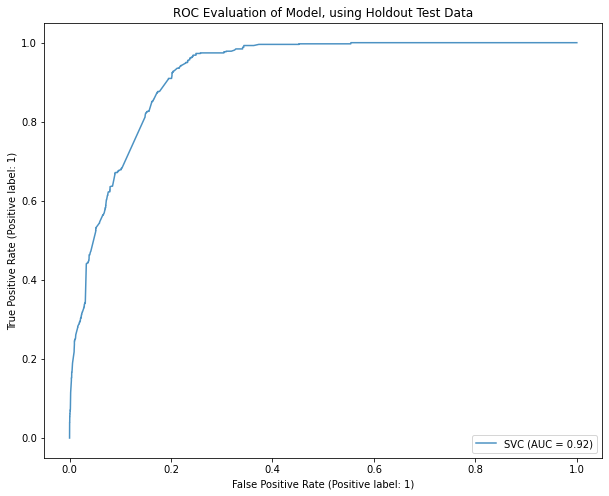

In [36]:
if TARGET_AVAIL == 1:
    print("Model: ", type(train_model).__name__)
    print("Model AUC: ", round(model_auc,3))
    %matplotlib inline
    plt.figure(figsize=(10,8))
    ax = plt.gca()
    model_disp = RocCurveDisplay.from_estimator(train_model, X_selected, y, ax=ax, alpha=0.8)
    plt.title("ROC Evaluation of Model, using Holdout Test Data")
    plt.show()
else:
    print("No Target label, thus, roc not plotted")

## Model Classification Report

In [37]:
#Define Target Names
target_names = ['Non-Chronic', 'Chronic']   

In [38]:
param = train_model.get_params()
print("The model loaded: ", type(train_model).__name__)
print("\nThe following are the trained model parameters: ")
param

The model loaded:  SVC

The following are the trained model parameters: 


{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [39]:
# get prediction
prediction = train_model.predict(X_selected)

In [40]:
# Generate Confusion Matrix
if TARGET_AVAIL == 1:
    conf_matrix = metrics.confusion_matrix(y, prediction)
else:
    print("Target not available, thus confucion matrix not generated.")

For Holdout Test Data:
Target:  ['Non-Chronic', 'Chronic']
Model:  SVC

Confusion Matrix: 
 [[6762  266]
 [ 384  313]] 



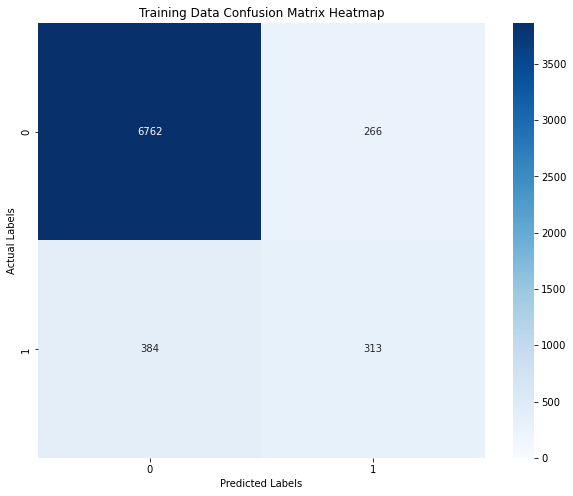

              precision    recall  f1-score   support

 Non-Chronic     0.9463    0.9622    0.9541      7028
     Chronic     0.5406    0.4491    0.4906       697

    accuracy                         0.9159      7725
   macro avg     0.7434    0.7056    0.7224      7725
weighted avg     0.9097    0.9159    0.9123      7725
 



In [41]:
# Generate Classification Report
if TARGET_AVAIL == 1:
    print("For Holdout Test Data:")
    print("Target: ", target_names)
    print("Model: ", type(train_model).__name__)
    print("\nConfusion Matrix: \n", conf_matrix, "\n")
    %matplotlib inline
    plt.figure(figsize=(10,8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', vmin=0, vmax=y.shape[0]/len(y.unique()), cmap="Blues")
    plt.title("Training Data Confusion Matrix Heatmap")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()
    print(metrics.classification_report(y, prediction,  digits=4, target_names=target_names), "\n" )
else:
    print("Target not available, thus classification report not generated.")

## Generate Score List

In [42]:
predict_series = pd.Series(prediction)

In [43]:
if TARGET_AVAIL == 1:
    df_scorelist = pd.DataFrame(columns = ["mem_id", "true_target", "prediction"])
    df_scorelist["mem_id"] = df["mem_id"]
    df_scorelist["true_target"] = y
    df_scorelist["prediction"] = predict_series
else:
    df_scorelist = pd.DataFrame(columns = ["mem_id", "prediction"])
    df_scorelist["member_id"] = member_id
    df_scorelist["prediction"] = predict_series

In [44]:
print(df_scorelist.head())

                                 mem_id  true_target  prediction
0  B3FDAFB4-2BCE-420E-98EF-04E57BEAEDC4            0           0
1  E6A4EC49-02D2-45A2-9F84-053D636A9675            1           0
2  4347A549-532F-4A2B-AD31-0670BB1CA8F3            0           0
3  1C5E3562-9894-41D3-B5C2-077E7D17FE8C            0           0
4  8217E3B4-97B8-4605-B339-08F1E96DF3C8            0           0


In [45]:
df_scorelist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7725 entries, 0 to 7724
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mem_id       7725 non-null   object
 1   true_target  7725 non-null   int64 
 2   prediction   7725 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 499.4+ KB


In [46]:
if type(train_model).__name__=="SVC":
    FILE_NAME = "scorelist_all_" + str(type(train_model).__name__) + str(param["kernel"]) + ".csv"
else:
    FILE_NAME = "scorelist_all_" + str(type(train_model).__name__) + ".csv"
print(FILE_NAME)
df_scorelist.to_csv(FILE_NAME, index=False)

scorelist_all_SVClinear.csv


@end